## Problem Statement/Goal
 - Pull insights and see what I can do to predict a change.
 
 People who did the most sessions preferred which method?
 What other habits were formed by using more of the app?
 
Marajuana might be a great way for people to treat depression, anxiety and stress, at least in the short term before finding more sustainable and longterm solutions.  If one could build a model which could predict the potential change for a consumer, then a company might then be able to reccomend targeted suggestions for a specific customer based on what would be most effective and helpful for them.

All metrics will be in Median Error because I'm shooting to be able to predict the error within a certain error threshold for the majority of the time and getting the mean would allow certain outliers to squew the results.

## Imports

In [89]:
# Standard & quality of life imports
import pandas as pd   #loc[row_indexer,col_indexer]
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from time import time
from datetime import datetime
%matplotlib inline

# Model prep & metric imports
import sklearn.metrics as metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

# Regression model imports
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Neural Network Imports
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking, Embedding
from keras import backend

df = pd.read_csv('./data/all_symptoms_cleaned.csv')

In [94]:
df.iloc[105:115,:]

,session,userid,gender,age,dose,time_lag,thc_%,cbd_%,before,after,...,has_cbd,dd_gender_vape,dd_gender_smoke,dd_gender_symptom_a,dd_gender_symptom_d,dd_sym_a_before,dd_sym_d_before,dd_sym_s_before,td_sym_a_gender_before,td_sym_d_gender_before
105,25,278,1,33,10,28.3,18.00,0.00,4,3,...,0,1,0,0,1,0,4,0,0,4
106,26,278,1,33,10,21.4,17.50,0.00,5,3,...,0,1,0,0,1,0,5,0,0,5
107,27,278,1,33,10,22.3,18.00,0.00,4,2,...,0,1,0,0,1,0,4,0,0,4
108,1,283,1,27,4,35.9,19.90,0.04,6,4,...,1,0,1,0,1,0,6,0,0,6
109,1,286,1,48,5,47.6,17.50,0.00,3,1,...,0,1,0,0,1,0,3,0,0,3
110,1,295,0,56,4,26.8,15.00,5.00,4,4,...,1,0,0,0,0,0,4,0,0,0
111,2,295,0,56,4,124.4,15.00,5.00,4,4,...,1,0,0,0,0,0,4,0,0,0
112,1,315,1,38,10,21.0,25.30,0.04,8,5,...,1,0,1,0,1,0,8,0,0,8
113,2,315,1,38,8,62.3,6.79,8.96,3,0,...,1,0,1,0,1,0,3,0,0,3
114,3,315,1,38,10,29.9,20.50,0.00,3,0,...,0,0,1,0,1,0,3,0,0,3


## Defining Model Running Function

In [106]:
df_results = pd.DataFrame(columns=['model', 'train_Median', 'test_Median', 'time', 'run_notes'])

def run_model(model, Train_Test_Tuple, results_dataframe, 
              run_notes = 'None', save = True, verbose = True):

    X_train, X_test, y_train, y_test = Train_Test_Tuple
    model      = model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)
    dict_model = {'model' : re.findall(r'^[^@]+\(', str(model))[0].strip("("),
    'time'         : datetime.fromtimestamp(time()).strftime('%m/%d/%Y, %H:%M:%S'),
    'train_Median' : metrics.median_absolute_error(y_train, pred_train),
    'test_Median'  : metrics.median_absolute_error(y_test, pred_test),
    'run_notes'    : run_notes}
    
    if verbose:# Printing current results
        print(dict_model['model'])
        print('Train : ' + str(dict_model['train_Median']))
        print('Test  : ' + str(dict_model['test_Median']))
    
    # Saving current results
    results_dataframe = results_dataframe.append(dict_model, ignore_index=True)
    if save == True:
        results_dataframe.to_csv('./data/modeling_results_' 
                        + datetime.fromtimestamp(time()).strftime('%m_%d_%Y'), 
                        index = False)
    
    return results_dataframe

# ML DF EDA

In [3]:
print('Number of users in study:', len(df['userid'].value_counts())) # (Post data cleaning)

Number of users in study: 1062


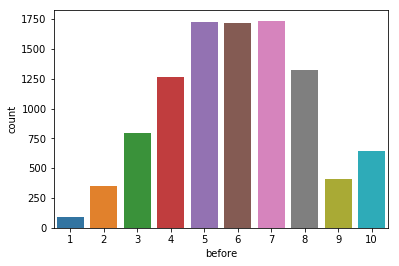

In [4]:
sns.countplot(df['before']);

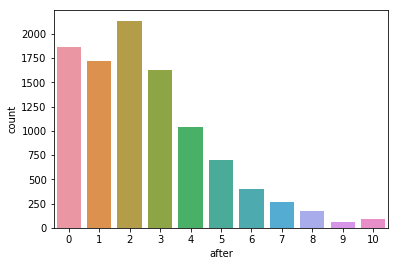

In [5]:
sns.countplot(df['after']);

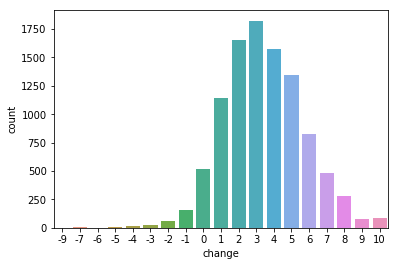

In [6]:
sns.countplot(df['change']);

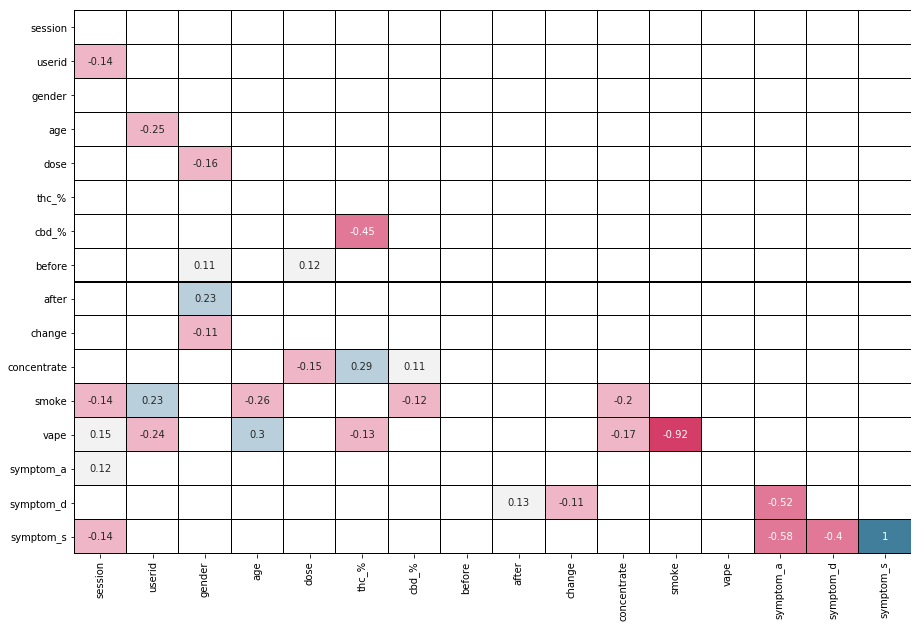

In [7]:
df_cor          = df.drop(['time_lag', 'dab_bubbler', 'dab_portable'],axis = 1).corr() 
# Dropped because nothing is signifigantly correlated to them
list_half_inner = []
list_half_outer = []

# Creating a blank-ish DF with the dementions that match the correlation matrix.
for i in range(df_cor.shape[0]):
    list_half_inner.append(True)
    list_half_outer.append(list_half_inner)
mask_half = pd.DataFrame(list_half_outer, columns= df_cor.columns, index=df_cor.columns)

# Turning it into a mask and cutting it in half.
for num in range(mask_half.shape[1]):
    mask_half.iloc[num,num:mask_half.shape[1]] = False

# Manually dropping certain values because they don't tell us anything by being correlated.
mask_half.loc['after','before'] = False
mask_half.loc['change','before':'after'] = False 

mask_half.iloc[df_cor.shape[0] - 1,df_cor.shape[1] - 1] = True
    
# Mask for limiting which correlations are shown.
mask_cor_limit = (df_cor > 0.1) | (df_cor < -0.1)
plt.figure(figsize=(15,10))

sns.heatmap(df_cor[mask_cor_limit][mask_half],
            annot = True, cbar=False, 
            linewidths= .01, linecolor='black', cmap=sns.diverging_palette(0, 230, n=7, center='light'));

---

# Baseline Models

The y variable will always be the 'after' column, thus we will define it one time here and won't have to re-define it later.
We are also removing redundant features dummie variables along with the change "feature" because it's a calculated variable that involved the target variable.

In [8]:
y = df['after']
series_symptom_stress = df['symptom_s']
df.drop(['concentrate', 'dab_bubbler','dab_portable', 'symptom_s', 'change'], axis = 1, inplace = True)

## Linear Regression
We'll start with a simple linear regression model to establish a baseline for the model.

In [108]:
X = df.drop('after', axis = 1)

print('Linear Regression with all features.\n')
df_results = run_model(LinearRegression(), train_test_split(X, y, random_state = 13), df_results, 
                      run_notes = "Linear Regression Baseline")

Linear Regression with all features.

LinearRegression
Train : 1.1230771672532451
Test  : 1.1516048442103257


The following is a Linear Regression with, essentially just the "before" feature. ("symptom_a" is also included to keep X two dementional.)


In [109]:
X = df[['before', 'symptom_a']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)
df_results = run_model(LinearRegression(), train_test_split(X, y, random_state = 13), df_results, 
                       run_notes = 'Only "Before" & "symptom_a" features.')

LinearRegression
Train : 1.2180226345718723
Test  : 1.2180226345718723


As far as linear regression is concerned, the most important value in our data is how somebody was feeling before attempting to medicate with cannabis.  This variable is so important that there is little change when nearly all other variables are removed.  This is a result of the fact that the before variable is strongly correlated to the target variable, while all other variables are compairitively weakly correlated the target variable.

## Random Forest

Out of the models I tried the one with the best consistent results was the Random Forrest Regressor.  I've also kept Linear Regression around so as to keep a consistent baseline.

In [111]:
X = df.drop('after', axis = 1) # Redefining the X variable for our full feature list.

df_results = run_model(RandomForestRegressor(), train_test_split(X, y, random_state = 13), df_results,
                      run_notes = "Randome Forest Baseline")

RandomForestRegressor
Train : 0.30000000000000004
Test  : 0.9


As Random Forrest gives the best test RMSE score, I'm going to be gridsearching on that.
The other benefit of going with Random Forrest is that I hope to one day digure out a consistent way to pull the actual diagram of the trees.  As such, in the future, I'll be able to get insights from the model where as going forward with the Gradient Boosting Regressor (or even using an XG Boost) would potentially result in a more accurate model, but the expected improvement would be less valuable to me than the potential future insights.

In [12]:
df_results.sort_values('test_Median').head(5)

,model,train_Median,test_Median,time,run_notes
2,RandomForestRegressor,0.300000,0.900000,"08/22/2019, 14:17:39",None
0,LinearRegression,1.127900,1.164952,"08/22/2019, 14:17:38",None
1,LinearRegression,1.218023,1.218023,"08/22/2019, 14:17:38","Only ""Before"" & ""symptom_a"" features."


---

# Feature Engineering

## Engineering Mathimatical Features

In [13]:
# Feature representing total canabinoids in a product
df['total_%'] = (df['thc_%'] + df['cbd_%'])

# Feature representing a scale of having more THC than CBD or vice verca.  
# Not on a scale for human interpretation.
df['strain_ratio'] = (df['thc_%'] - df['cbd_%'])/(df['thc_%'] + df['cbd_%'])

## Gridsearching Time Bins

While I originally felt that there was some features which could be pulled from the time_lag feature if binned. I then decided to start with a guess of which splits would be the most useful and from there make a gridsearch-like code block with the correlation to the target variable to find what splits would actually have the most liklihood of being useful to the model.
I used a mock up of a gridsearch to find the most correlated combination of 3 different splits in the eature to find the one which would be most useful.
The next cell is the gridsearching code I used on the last set of numbers I tested.  After that is code for assigning it to the df and visualizing where the lines are in the actual data.

In [9]:
list_o_dicts = []
for low in [0, 14, 14.5, 15]:
    for mid in [0, 19, 19.5]:
        for high in [0, 100, 105]:
            def sorting(row):    
                if row['time_lag'] < low:
                    result = .1
                elif row['time_lag'] < mid:
                    result = .2
                elif row['time_lag'] < high:
                    result = .3
                else: 
                    result = .4
                return result
            df['binned_time'] = df.apply(sorting, axis=1)
            list_o_dicts.append({
                'low'  : low,
                'mid'  : mid,
                'high' : high,
                'corr' : np.abs(df.corrwith(df['after'])['binned_time'])
            })
df_grid = pd.DataFrame(list_o_dicts, columns=['corr','low','mid','high'])
df_grid = df_grid.sort_values('corr', ascending = False).head(10)
df_grid

,corr,low,mid,high
20,0.069518,14.5,0.0,105
11,0.069165,14.0,0.0,105
26,0.068723,14.5,19.5,105
23,0.068637,14.5,19.0,105
29,0.068630,15.0,0.0,105
18,0.068618,14.5,0.0,0
17,0.068584,14.0,19.5,105
14,0.068497,14.0,19.0,105
19,0.068494,14.5,0.0,100
9,0.068238,14.0,0.0,0


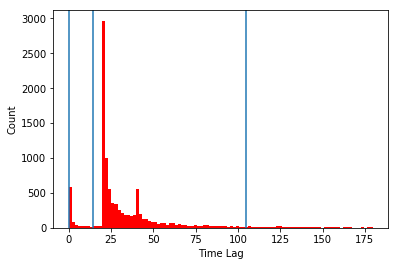

In [10]:
best_low, best_mid, best_high = df_grid.iloc[0,1], df_grid.iloc[0,2], df_grid.iloc[0,3]

def sorting(row):    
    if row['time_lag'] < best_low:
        result = .1
    elif row['time_lag'] < best_mid:
        result = .2
    elif row['time_lag'] < best_high:
        result = .3
    else: 
        result = .4
    return result
df['binned_time'] = df.apply(sorting, axis=1)
plt.ylabel('Count')
plt.xlabel('Time Lag')
plt.axvline(x = best_low)
plt.axvline(x = best_mid)
plt.axvline(x = best_high)
plt.hist(df['time_lag'], bins = 100, color='red');

## Gridsearching Cannabis percentage classes
While looking at the scatter plot of thc % and cbd % I noticed roughly three clusters which could be seperated by two lines.  While my original idea was to seperate those three clusters, I used a similar gridsearching technique as the one above and found the following splits to be more correlative.  The immediatly next cell shows the splits I originally had in mind.  Following that is the last gridsearch I ran and finally the splits I ended up with.

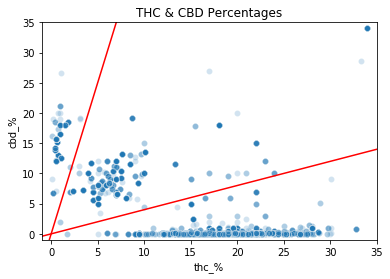

In [11]:
axes = plt.gca()
axes.set_xlim([-1,35])
axes.set_ylim([-1,35])
axes.set_title('THC & CBD Percentages')
sns.scatterplot(df['thc_%'],df['cbd_%'], alpha=0.2);
line = np.linspace(-500,500)
plt.plot(line, 5 * line, '-r');
plt.plot(line, 0.4 * line, '-r');

In [12]:
list_o_dicts = []
for slope_1 in [0.025, 0.05, 0.1]:
    for slope_2 in [0.7, 0.8, 0.85, 0.9]:
        def sorting(row):    
            if row['cbd_%'] < (row['thc_%'] * slope_1):
                result = 1
            elif row['cbd_%'] > (row['thc_%'] * slope_2):
                result = .5
            else: 
                result = 0
            return result
        df['strain_class'] = df.apply(sorting, axis=1)
        list_o_dicts.append({
            'slope_1'  : slope_1,
            'slope_2'  : slope_2,
            'corr' : np.abs(df.corrwith(df['after'])['strain_class'])
        })
df_grid = pd.DataFrame(list_o_dicts)
df_grid = df_grid.sort_values('corr', ascending= False).head(10)
df_grid

,corr,slope_1,slope_2
5,0.055640,0.050,0.80
6,0.055640,0.050,0.85
7,0.055418,0.050,0.90
4,0.053869,0.050,0.70
1,0.047656,0.025,0.80
2,0.047656,0.025,0.85
3,0.047503,0.025,0.90
0,0.045806,0.025,0.70
9,0.033004,0.100,0.80
10,0.033004,0.100,0.85


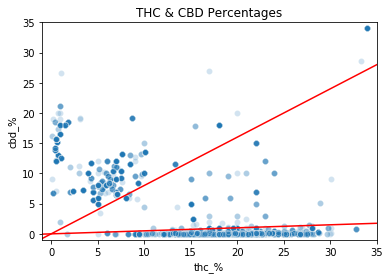

In [13]:
best_slope_1, best_slope_2 = df_grid.iloc[0,1], df_grid.iloc[0,2]


def sorting(row):    
    if row['cbd_%'] < (row['thc_%'] * best_slope_1):
        result = 1
    elif row['cbd_%'] > (row['thc_%'] * best_slope_2):
        result = .5
    else: 
        result = 0
    return result
df['strain_class'] = df.apply(sorting, axis=1)

axes = plt.gca()
axes.set_xlim([-1,35])
axes.set_ylim([-1,35])
axes.set_title('THC & CBD Percentages')
sns.scatterplot(df['thc_%'],df['cbd_%'], alpha=0.2);
line = np.linspace(-500,500)
plt.plot(line, best_slope_1 * line, '-r');
plt.plot(line, best_slope_2 * line, '-r');

Consistently, the most correlated lies were when both were set to 0, thus seperating the data into those which had cbd and those which did not.  Thus, I excluded those as possibilities and instead made a seperate feature for just representing if cbd was present in the data or not.  This should allow the model to have that many more options of how to split the data.

In [14]:
def sort(x):
    if x == 0:
        result = 0
    else:
        result = 1
    return result
df['has_cbd'] = df['cbd_%'].map(lambda x: sort(x))

Gridsearching Age Bins was attempted but resulted very very little correlation and as such, I did not follow that path.

While these were useful things to try, looking back I realize that the problem with attempting to make features fromt his while using a random forrest is that the model could easily make these splits of it's own accord.  
In retrosepct I believe that the best features to engineer would be those that would provide a different scale that would then be more likely to be correlative to the target variable.

## Combining Dummies

In [15]:
# dd stands for "Double Dummies"
df['dd_gender_vape']  = df['gender'] * df['vape']
df['dd_gender_smoke'] = df['gender'] * df['smoke']
df['dd_gender_symptom_a'] = df['gender'] * df['symptom_a']
df['dd_gender_symptom_d'] = df['gender'] * df['symptom_d']
#df['dd_sym_a_vape']  = df['symptom_a'] * df['vape'] 
#df['dd_sym_d_vape']  = df['symptom_d'] * df['vape'] 
#df['dd_sym_a_smoke'] = df['symptom_a'] * df['smoke']
#df['dd_sym_d_smoke'] = df['symptom_d'] * df['smoke']
df['dd_sym_a_before'] = df['symptom_a'] * df['before']
df['dd_sym_d_before'] = df['symptom_d'] * df['before']
df['dd_sym_s_before'] = series_symptom_stress * df['before'] 
# Stress Boolian returned because it's more info.

# td stands for "Triple Dummies"
df['td_sym_a_gender_before'] = df['gender'] * df['dd_sym_a_before']
df['td_sym_d_gender_before'] = df['gender'] * df['dd_sym_d_before']
df['td_sym_s_gender_before'] = df['gender'] * df['dd_sym_s_before']

After the feature pruning section I decided to drop any double features that didn't involve the Before or Gender features.

## Modeling (Post Feature Creation & with Standardization)

In [116]:
X = df.drop('after', axis = 1)
print("No Scaling")
df_results = run_model(RandomForestRegressor(), train_test_split(X, y, random_state = 13), df_results, 
                       run_notes= "Run with all of the engineered features")

X = Normalizer().fit_transform(df.drop('after', axis = 1))
print("\nNormalizer")
df_results = run_model(RandomForestRegressor(), train_test_split(X, y, random_state = 13), df_results, 
                       run_notes= "Run with all engineered features and normalized.")

X = MinMaxScaler().fit_transform(df.drop('after', axis = 1))
print("\nMinMaxScaler")
df_results = run_model(RandomForestRegressor(), train_test_split(X, y, random_state = 13), df_results, 
                       run_notes= "Run with all engineered features and MinMaxed.")

X = StandardScaler().fit_transform(df.drop('after', axis = 1))
print("\nStandardScaler")
df_results = run_model(RandomForestRegressor(), train_test_split(X, y, random_state = 13), df_results, 
                       run_notes= "Run with all engineered features and Standardized.")

No Scaling
RandomForestRegressor
Train : 0.30000000000000004
Test  : 0.9

Normalizer
RandomForestRegressor
Train : 0.3
Test  : 0.8999999999999999

MinMaxScaler
RandomForestRegressor
Train : 0.30000000000000004
Test  : 0.8999999999999999

StandardScaler
RandomForestRegressor
Train : 0.30000000000000004
Test  : 0.8999999999999999


Due to the fact that the standardizers tend to do very little for the model when measuring the median error, except for adding many decimal points to the results, I'll be skipping them.  (It should be noted that the Normalizer will ocasionlly perform better, but it's inconsistent enough that I've decided to just leave it out as well.  It was also the best standardization method for RMSE.)

In [118]:
df_results.sort_values('test_Median').head(7)

,model,train_Median,test_Median,time,run_notes
12,RandomForestRegressor,0.3,0.9,"08/25/2019, 19:13:59",Run with all engineered features and Standardi...
22,RandomForestRegressor,0.3,0.9,"08/25/2019, 19:14:53",Run with all engineered features and normalized.
20,RandomForestRegressor,0.3,0.9,"08/25/2019, 19:14:42",Run with all engineered features and Standardi...
18,RandomForestRegressor,0.3,0.9,"08/25/2019, 19:14:41",Run with all engineered features and normalized.
17,RandomForestRegressor,0.3,0.9,"08/25/2019, 19:14:40",Run with all the engineered features
16,RandomForestRegressor,0.3,0.9,"08/25/2019, 19:14:33",Run with all engineered features and Standardi...
15,RandomForestRegressor,0.3,0.9,"08/25/2019, 19:14:32",Run with all engineered features and MinMaxed.


---

# Feature Importance (PCA, Correlation and More!)

In [26]:
abs(df.corrwith(df['after'])).sort_values(ascending = False)

after                     1.000000
before                    0.420261
td_sym_d_gender_before    0.263370
dd_sym_d_before           0.232150
gender                    0.226082
dd_gender_vape            0.205179
dd_gender_symptom_d       0.192911
td_sym_a_gender_before    0.137038
symptom_d                 0.126244
age                       0.080671
dd_gender_symptom_a       0.075977
dd_gender_smoke           0.073319
vape                      0.072438
userid                    0.070336
binned_time               0.069518
symptom_a                 0.061898
has_cbd                   0.055763
strain_class              0.055640
smoke                     0.055589
dd_sym_a_before           0.040280
dose                      0.027489
session                   0.025282
dd_sym_s_before           0.024060
thc_%                     0.011204
time_lag                  0.010714
cbd_%                     0.004369
dtype: float64

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)
model = RandomForestRegressor().fit(X_train,y_train)
pd.DataFrame(model.feature_importances_,
            index = df.drop('after', axis = 1).columns,
            columns=['importance']).sort_values('importance',ascending=False)

,importance
before,0.134386
session,0.075143
strain_class,0.071373
age,0.070339
thc_%,0.060946
dose,0.056948
has_cbd,0.051348
userid,0.050451
gender,0.047739
binned_time,0.045591


There's a lot of conflicting information between the features that are stated to be important by the Random Forest versus the correlative features.  The only easily reliable take away is that we can drop the duplicated features which don't include gender or how one was feeling before.

In [28]:
pca = PCA(svd_solver='auto')
X = pca.fit_transform(X)

print('Cumulative explained variance: ', np.cumsum(pca.explained_variance_ratio_))

Cumulative explained variance:  [0.74014488 0.88486921 0.95646131 0.97356168 0.98259934 0.98885746
 0.99268617 0.99625726 0.99780178 0.99899917 0.99967986 0.99983516
 0.99989637 0.99994167 0.9999636  0.99997484 0.99998409 0.99999008
 0.99999511 0.99999753 0.99999858 0.9999994  0.99999977 1.
 1.        ]


According to the PCA having only 10 features will account for 0.99899917% of the variance.  Thus I will be setting the components to 10.

In [29]:
X = PCA(n_components = 10, svd_solver='auto').fit_transform(X)

### Modeling (Post Redundant Feature Dropping)

In [30]:
df_results = run_model(RandomForestRegressor(), train_test_split(X, y, random_state = 13), df_results, 
                       run_notes = "Pruned Features")

RandomForestRegressor
Train : 0.3999999999999999
Test  : 1.1


In [31]:
df_results.sort_values('test_Median').head(5)

,model,train_Median,test_Median,time,run_notes
1,RandomForestRegressor,0.3,0.85,"08/22/2019, 14:18:39",Run with all engineered features and normalized.
0,RandomForestRegressor,0.3,0.90,"08/22/2019, 14:18:38",Run with all the engineered features
3,RandomForestRegressor,0.3,0.90,"08/22/2019, 14:18:40",Run with all engineered features and Standardi...
4,RandomForestRegressor,0.3,0.90,"08/22/2019, 14:19:00",Run with all engineered features and normalized.
5,RandomForestRegressor,0.3,0.90,"08/22/2019, 14:19:05",Run with all engineered features and normalized.
6,RandomForestRegressor,0.3,0.90,"08/22/2019, 14:19:07",Run with all engineered features and normalized.
2,RandomForestRegressor,0.3,0.90,"08/22/2019, 14:18:39",Run with all engineered features and MinMaxed.
7,RandomForestRegressor,0.4,1.10,"08/22/2019, 14:35:14",Pruned Features


Unfortunatly, The pruning of features has only resulted in a less efficient model.  As such I will be leaving the current set of features as is.

------------------------

# Final Gridsearching

 - n_estimators = number of trees in the foreset
 - max_features = max number of features considered for splitting a node
 - max_depth = max number of levels in each decision tree
 - min_samples_split = min number of data points placed in a node before the node is split
 - min_samples_leaf = min number of data points allowed in a leaf node

In [86]:
#df_gridsearch = pd.DataFrame()
# Last gridsearch after about 10 trials.
params = {
    'n_estimators'      : [135],
    'min_samples_split' : [5, 6],
    'min_samples_leaf'  : [2]
}
grid_RForest = GridSearchCV(RandomForestRegressor(), params, cv=3, n_jobs= 3, verbose = 1)

X = df.drop('after', axis = 1)
df_results = run_model(grid_RForest, train_test_split(X, y, random_state = 13), df_results)  
df_results['run_notes'][df_results.shape[0] - 1] = "Best Params: " + str(grid_RForest.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:    8.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor
Train : 0.44061848645182
Test  : 0.8767068836513281


While the hyperparameters where left as the following, the slight variations in a better or worse model when compairing finer details, such as 125 or 135 estimators, or the minimum samples split being 5 or 6 ended up mostly being up to random chance.
The results of the gridsearch being so inconsistent and sporratic tells me that this random chance is playing too high of a factor to get much better of a score than, on average, about 0.867 in the Median Error.  I suspect that this is a result of not having a complex enough model or not having enough information that would be able to more accuratly predict the outcomes of how one will feel after ingesting the cannabis.

In [87]:
df_results['run_notes'][df_results.shape[0] - 1]

"Best Params: {'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 135}"

In [88]:
df_results.sort_values('test_Median').head(10)

,model,train_Median,test_Median,time,run_notes
1,RandomForestRegressor,0.300000,0.850000,"08/22/2019, 14:18:39",Run with all engineered features and normalized.
13,"GridSearchCV(cv=3, error_score='raise',\n ...",0.435090,0.861693,"08/22/2019, 16:23:19","Best Params: {'min_samples_leaf': 2, 'min_samp..."
11,"GridSearchCV(cv=3, error_score='raise',\n ...",0.412290,0.864246,"08/22/2019, 16:17:45","Best Params: {'min_samples_leaf': 2, 'min_samp..."
14,"GridSearchCV(cv=3, error_score='raise',\n ...",0.413841,0.867601,"08/22/2019, 16:25:34","Best Params: {'min_samples_leaf': 2, 'min_samp..."
9,"GridSearchCV(cv=3, error_score='raise',\n ...",0.410720,0.867821,"08/22/2019, 16:07:38","Best Params: {'max_features': 'auto', 'min_sam..."
12,"GridSearchCV(cv=3, error_score='raise',\n ...",0.384018,0.874797,"08/22/2019, 16:19:52","Best Params: {'min_samples_leaf': 1, 'min_samp..."
10,"GridSearchCV(cv=3, error_score='raise',\n ...",0.440176,0.874922,"08/22/2019, 16:12:37","Best Params: {'min_samples_leaf': 2, 'min_samp..."
15,"GridSearchCV(cv=3, error_score='raise',\n ...",0.440618,0.876707,"08/22/2019, 16:26:25","Best Params: {'min_samples_leaf': 2, 'min_samp..."
0,RandomForestRegressor,0.300000,0.900000,"08/22/2019, 14:18:38",Run with all the engineered features
3,RandomForestRegressor,0.300000,0.900000,"08/22/2019, 14:18:40",Run with all engineered features and Standardi...


---

## Splitting Train & Test by a User's Last Session

In [95]:
list_last_session_indexes = []
list_ids = [i for i in df['userid'].unique()]
for i in list_ids:
    mask = df['userid'] == i
    list_last_session_indexes.append(df[mask]['session'].argmax())

df_test  = df.loc[list_last_session_indexes]
df_train = df.drop(list_last_session_indexes)

In [97]:
num = 1
mask = df_test['session'] > num
df_test_without_newbies = df_test[mask]
print('observations in training set:', df_train.shape[0])
print('Observations with more than', num, 'sessions:', df_test_without_newbies.shape[0])
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test_without_newbies.drop('after', axis = 1)
y_test  = df_test_without_newbies['after']
df_results = run_model(RandomForestRegressor(), (X_train, X_test, y_train, y_test), df_results, 
                       run_notes= "Run with splits along sesson" + str(num) + ".")

observations in training set: 9002
Observations with more than 1 sessions: 647
RandomForestRegressor
Train : 0.3
Test  : 1.0


Across the board it's worse than just pulling random samples.  This is unfortunate for my hopes of getting the RMSE score down, but I don't regret putting in the work to represent 

In [98]:
num = 5
mask = df_test['session'] > num
df_test_without_newbies = df_test[mask]
print('Observations with more than', num, 'sessions:', df_test_without_newbies.shape[0])
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test_without_newbies.drop('after', axis = 1)
y_test  = df_test_without_newbies['after']
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results, 
                       run_notes= "Run with splits along sesson" + str(num) + ".")

Observations with more than 5 sessions: 273
RandomForestRegressor
Train : 0.3
Test  : 0.8999999999999999


Hmm.  While it's still not enough in range of the baseline, it IS better than with those for whome it's only been thier first time.

In [99]:
list_dict_splits = []
for num in range(31):
    mask = df_test['session'] > num
    df_test_without_newbies = df_test[mask]
    X_train = df_train.drop('after', axis = 1)
    y_train = df_train['after']
    X_test  = df_test_without_newbies.drop('after', axis = 1)
    y_test  = df_test_without_newbies['after']
    list_dict_splits.append({
        'Median_error_1' : metrics.median_absolute_error(y_test,
            RandomForestRegressor().fit(X_train, y_train).predict(X_test)),
        'Median_error_2' : metrics.median_absolute_error(y_test,
            RandomForestRegressor().fit(X_train, y_train).predict(X_test)),
        'Median_error_3' : metrics.median_absolute_error(y_test,
            RandomForestRegressor().fit(X_train, y_train).predict(X_test)),
        'Observations' : df_test_without_newbies.shape[0],
        'Sess_more_than' : num})

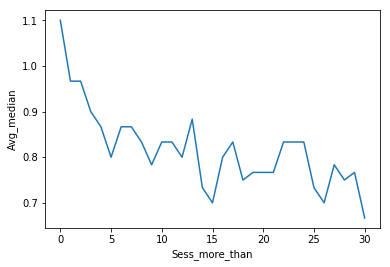

In [100]:
df_splits = pd.DataFrame(list_dict_splits)

df_splits['Avg_median'] = df_splits.loc[:,"Median_error_1":"Median_error_3"].mean(axis = 1)

sns.lineplot(df_splits['Sess_more_than'], df_splits['Avg_median']);

Observations over 30: 30


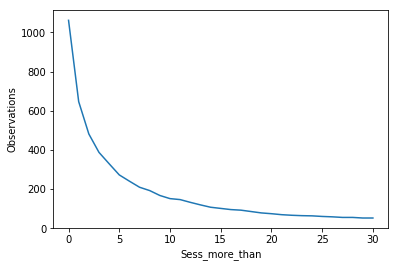

In [101]:
sns.lineplot(df_splits['Sess_more_than'],df_splits['Observations']);

print('Observations over 30:', df_splits['Sess_more_than'][30])

This shows that the more data we're given about a user the more accurate we can make our predictions.  [Most notably the difference of 0.2 accuracy between 0 and 5, 0.1 from that to 18-ish]

In [102]:
num = 15
mask = df_test['session'] > num
df_test_without_newbies = df_test[mask]
print('Observations with more than', num, 'sessions:', df_test_without_newbies.shape[0])
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test_without_newbies.drop('after', axis = 1)
y_test  = df_test_without_newbies['after']
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results, 
                       run_notes= "Run with splits along sesson" + str(num) + ".")

Observations with more than 15 sessions: 102
RandomForestRegressor
Train : 0.2999999999999998
Test  : 0.8500000000000003


In [105]:
num = 30
mask = df_test['session'] > num
df_test_without_newbies = df_test[mask]
print('Observations with more than', num, 'sessions:', df_test_without_newbies.shape[0])
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test_without_newbies.drop('after', axis = 1)
y_test  = df_test_without_newbies['after']
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results, 
                       run_notes= "Run with splits along sesson" + str(num) + ".")

Observations with more than 30 sessions: 53
RandomForestRegressor
Train : 0.3
Test  : 0.8000000000000007


This process mimicks a real world application of processing the data.

---